In [4]:
# Install the ChEMBL web service package
!pip install chembl_webresource_client

import pandas as pd
from chembl_webresource_client.new_client import new_client
import numpy as np

print("Libraries installed successfully!")

Libraries installed successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
import pandas as pd
import os

# Load the file you manually uploaded
# Make sure the filename inside the quotes matches exactly!

# Check what files are in the current directory
print("Files in current directory:", os.listdir('.'))

df = pd.read_csv('CHEMBL1824_bioactivity.csv', sep=';') # ChEMBL CSVs use semicolons ';'

print("File loaded manually!")
df.head()

Files in current directory: ['.config', 'CHEMBL1824_bioactivity.csv', 'sample_data']
File loaded manually!


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value,Value
0,CHEMBL2205426,NaN,NaN,414.47,0.0,3.83,49,CC(C)(C)Nc1c(Nc2ccnc(Nc3ccc(-c4ccncc4)cc3)n2)c...,Ki,'>',...,CHEMBL2203238,1,Scientific Literature,Bioorg Med Chem Lett,2012.0,NaN,NaN,NaN,NaN,1400.00
1,CHEMBL1241674,NaN,NaN,308.35,0.0,2.84,PP242,CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21,Inhibition,'=',...,CHEMBL1240340,1,Scientific Literature,Nat Chem Biol,2008.0,NaN,NaN,NaN,NaN,3.00
2,CHEMBL1163819,NaN,NaN,534.68,2.0,6.27,6,CCOC(=O)c1cc2cc(Nc3ncnc4cc(OC)c(OCCCN5CCC(C)CC...,Inhibition,'=',...,CHEMBL1165936,1,Scientific Literature,Bioorg Med Chem,2010.0,NaN,NaN,NaN,NaN,57.01
3,CHEMBL2333989,NaN,NaN,296.33,0.0,2.97,23,COc1cc2ncnc(Nc3ccc(N)cc3)c2cc1OC,Inhibition,'=',...,CHEMBL3217494,1,Scientific Literature,Medchemcomm,2010.0,NaN,NaN,NaN,NaN,5.00
4,CHEMBL4071161,TIRABRUTINIB,4.0,454.49,0.0,2.75,3; GS-4059; ONO-4059,CC#CC(=O)N1CC[C@@H](n2c(=O)n(-c3ccc(Oc4ccccc4)...,Inhibition,'=',...,CHEMBL4020831,1,Scientific Literature,J Med Chem,2018.0,NaN,NaN,NaN,NaN,7.00


In [6]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 56.8 MB/s eta 0:00:00


In [7]:
import pandas as pd

# 1. Load the file (Note: We use sep=';' because ChEMBL files use semicolons)
df = pd.read_csv('CHEMBL1824_bioactivity.csv', sep=';')

# 2. Select only the columns we need
# We rename them to be easier to type later
df = df[['Molecule ChEMBL ID', 'Smiles', 'Standard Value', 'Standard Units']]
df.columns = ['molecule_chembl_id', 'smiles', 'standard_value', 'standard_units']

# 3. Drop missing values
df_clean = df.dropna(subset=['standard_value', 'smiles'])

# 4. Filter for correct units (We only want 'nM')
df_clean = df_clean[df_clean['standard_units'] == 'nM']

# 5. Convert standard_value to numbers
df_clean['standard_value'] = pd.to_numeric(df_clean['standard_value'])

# 6. Label Active (1) vs Inactive (0)
# Rule: If IC50 <= 1000 nM, it's Active.
def label_molecule(value):
    if value <= 1000:
        return 1
    else:
        return 0

df_clean['activity_label'] = df_clean['standard_value'].apply(label_molecule)

# 7. Save the Clean File
df_clean.to_csv('her2_phase1_data.csv', index=False)

print(f"✅ Success! Cleaned data saved. Rows: {len(df_clean)}")
print(df_clean.head())

✅ Success! Cleaned data saved. Rows: 5121
  molecule_chembl_id                                             smiles  \
0      CHEMBL2205426  CC(C)(C)Nc1c(Nc2ccnc(Nc3ccc(-c4ccncc4)cc3)n2)c...   
5       CHEMBL193578   Clc1cc(Nc2ncnc3cccc(OC4CCOCC4)c23)ccc1OCc1ccccn1   
6        CHEMBL55204           N#C/C(=C\c1ccc(O)c(O)c1)C(=O)c1ccc(F)cc1   
7       CHEMBL429827          Cc1ccn2ncnc(Nc3ccc4c(cnn4Cc4ccccc4)c3)c12   
8       CHEMBL255968  C[C@H](Oc1cccc2ncnc(Nc3ccc(OCc4ccccn4)c(Cl)c3)...   

   standard_value standard_units  activity_label  
0          1400.0             nM               0  
5            24.0             nM               1  
6         13600.0             nM               0  
7           110.0             nM               1  
8            43.0             nM               1  


In [8]:
# Install RDKit (Required for chemistry calculations)
!pip install rdkit

import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

# 1. Define the Calculator Function
def lipinski(smiles, verbose=False):
    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData = np.arange(1,1)
    i = 0
    for mol in moldata:
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt, desc_MolLogP, desc_NumHDonors, desc_NumHAcceptors])

        if(i==0):
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i = i + 1

    columnNames = ["MW", "LogP", "NumHDonors", "NumHAcceptors"]
    df = pd.DataFrame(data=baseData, columns=columnNames)
    return df

# 2. Run the calculation (Takes ~1 minute)
print("Calculating descriptors... please wait.")
df_lipinski = lipinski(df_clean['smiles'])

# 3. Combine with original data
df_combined = pd.concat([df_clean.reset_index(drop=True), df_lipinski], axis=1)

# 4. Save Phase 2 Data
df_combined.to_csv('her2_phase2_data.csv', index=False)
print("✅ Phase 2 Complete! Saved 'her2_phase2_data.csv'")
print(df_combined.head())

Calculating descriptors... please wait.
✅ Phase 2 Complete! Saved 'her2_phase2_data.csv'
  molecule_chembl_id                                             smiles  \
0      CHEMBL2205426  CC(C)(C)Nc1c(Nc2ccnc(Nc3ccc(-c4ccncc4)cc3)n2)c...   
1       CHEMBL193578   Clc1cc(Nc2ncnc3cccc(OC4CCOCC4)c23)ccc1OCc1ccccn1   
2        CHEMBL55204           N#C/C(=C\c1ccc(O)c(O)c1)C(=O)c1ccc(F)cc1   
3       CHEMBL429827          Cc1ccn2ncnc(Nc3ccc4c(cnn4Cc4ccccc4)c3)c12   
4       CHEMBL255968  C[C@H](Oc1cccc2ncnc(Nc3ccc(OCc4ccccn4)c(Cl)c3)...   

   standard_value standard_units  activity_label       MW     LogP  \
0          1400.0             nM               0  414.469  3.83220   
1            24.0             nM               1  462.937  5.55860   
2         13600.0             nM               0  283.258  3.02678   
3           110.0             nM               1  354.417  4.17932   
4            43.0             nM               1  477.952  4.85630   

   NumHDonors  NumHAcceptors  
0       

In [9]:
import numpy as np

# 1. Cap values to prevent errors
# (If a value is too high, we cap it at 100,000,000 to avoid infinity errors)
df_combined = pd.read_csv('her2_phase2_data.csv') # Reload to be safe
df_combined['standard_value_norm'] = df_combined['standard_value'].apply(lambda x: min(x, 100000000))

# 2. Define the pIC50 function
# It converts 10nM -> 8.0 (High potency)
# It converts 10,000nM -> 5.0 (Low potency)
def pIC50(input):
    pIC50 = []
    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Convert nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis=1)
    return x

# 3. Apply it
df_final = pIC50(df_combined)
df_final.to_csv('her2_phase3_data.csv', index=False)

print("pIC50 column added.")
print(df_final.head())

pIC50 column added.
  molecule_chembl_id                                             smiles  \
0      CHEMBL2205426  CC(C)(C)Nc1c(Nc2ccnc(Nc3ccc(-c4ccncc4)cc3)n2)c...   
1       CHEMBL193578   Clc1cc(Nc2ncnc3cccc(OC4CCOCC4)c23)ccc1OCc1ccccn1   
2        CHEMBL55204           N#C/C(=C\c1ccc(O)c(O)c1)C(=O)c1ccc(F)cc1   
3       CHEMBL429827          Cc1ccn2ncnc(Nc3ccc4c(cnn4Cc4ccccc4)c3)c12   
4       CHEMBL255968  C[C@H](Oc1cccc2ncnc(Nc3ccc(OCc4ccccn4)c(Cl)c3)...   

   standard_value standard_units  activity_label       MW     LogP  \
0          1400.0             nM               0  414.469  3.83220   
1            24.0             nM               1  462.937  5.55860   
2         13600.0             nM               0  283.258  3.02678   
3           110.0             nM               1  354.417  4.17932   
4            43.0             nM               1  477.952  4.85630   

   NumHDonors  NumHAcceptors     pIC50  
0         3.0            8.0  5.853872  
1         1.0            7

/tmp/ipython-input-149239533.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='activity_label', data=df_final, palette='Set2')
/tmp/ipython-input-149239533.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='activity_label', y='pIC50', data=df_final, palette='Set2')


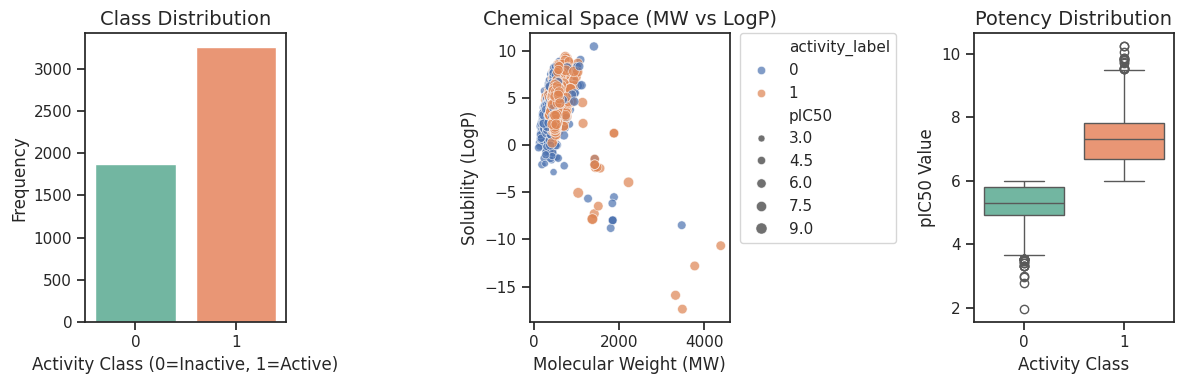

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the visual style
sns.set(style='ticks')
plt.figure(figsize=(12, 4))

# PLOT 1: Frequency Plot (Active vs Inactive)
plt.subplot(1, 3, 1)
sns.countplot(x='activity_label', data=df_final, palette='Set2')
plt.xlabel('Activity Class (0=Inactive, 1=Active)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Class Distribution', fontsize=14)

# PLOT 2: Scatter Plot (Chemical Space)
# MW (Weight) vs LogP (Solubility)
plt.subplot(1, 3, 2)
sns.scatterplot(x='MW', y='LogP', data=df_final, hue='activity_label', alpha=0.7, size='pIC50')
plt.xlabel('Molecular Weight (MW)', fontsize=12)
plt.ylabel('Solubility (LogP)', fontsize=12)
plt.title('Chemical Space (MW vs LogP)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# PLOT 3: Box Plot (Potency Distribution)
plt.subplot(1, 3, 3)
sns.boxplot(x='activity_label', y='pIC50', data=df_final, palette='Set2')
plt.xlabel('Activity Class', fontsize=12)
plt.ylabel('pIC50 Value', fontsize=12)
plt.title('Potency Distribution', fontsize=14)

plt.tight_layout()
plt.savefig('her2_eda_plots.png') # Saves the image so you can download it
plt.show()

Phase 4: Deep Learning: Building AI model

Step 1: Generate Molecular Fingerprints

In [11]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data (Just to be safe)
df = pd.read_csv('her2_phase3_data.csv')

# 2. Define the NEW Fingerprint Function (Silent & Modern)
def create_fingerprints_clean(smiles_list):
    # We create the generator ONCE (instead of 5000 times)
    # This prevents the warning spam
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

    fingerprints = []
    count = 0

    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        if mol is not None:
            # Use the new generator
            fp = mfpgen.GetFingerprint(mol)
            fingerprints.append(list(fp))
        else:
            # Handle invalid smiles by adding a blank fingerprint (zeros)
            fingerprints.append([0] * 2048)

    return np.array(fingerprints)

print("Generating fingerprints using the modern RDKit Generator...")
X = create_fingerprints_clean(df['smiles'])
y = df['activity_label']

print("✅ Success! Fingerprints generated without warnings.")
print(f"Input Data Shape: {X.shape}")

Generating fingerprints using the modern RDKit Generator...
✅ Success! Fingerprints generated without warnings.
Input Data Shape: (5121, 2048)


Step 2: Split the Data

Training Set (80%): The AI studies these.
Test Set (20%): The AI has never seen these. We use them to grade the model.

In [12]:
# Split the data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training on {len(X_train)} compounds")
print(f"Testing on {len(X_test)} compounds")

Training on 4096 compounds
Testing on 1025 compounds


Step 3: Train the "Baseline" Model

Before building a complex Deep Neural Network, you must train a Random Forest first.

In [13]:
# 1. Initialize the Random Forest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Train it (Fit)
print("Training the Random Forest model... (this takes 1-2 minutes)")
model_rf.fit(X_train, y_train)

# 3. Predict on the Test Set
y_pred = model_rf.predict(X_test)

print("Training Complete!")

Training the Random Forest model... (this takes 1-2 minutes)
Training Complete!


Step 4: Evaluate the Performance

Model Accuracy: 89.27%

Detailed Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       368
           1       0.91      0.92      0.92       657

    accuracy                           0.89      1025
   macro avg       0.89      0.88      0.88      1025
weighted avg       0.89      0.89      0.89      1025



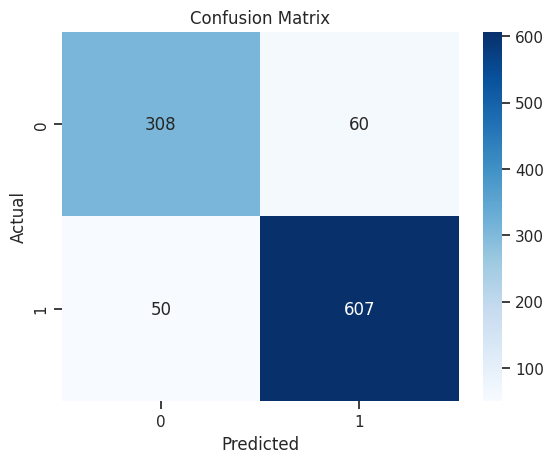

In [14]:
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred))

# Visualise the Confusion Matrix (Where did it make mistakes?)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Phase 5: Building the Deep Learning Model


We will build a Multilayer Perceptron (MLP) using TensorFlow/Keras. This is a true "Deep Learning" architecture.

**The Architecture:**

Input Layer: Reads the 2,048-bit fingerprint.

Hidden Layers: Two heavy layers (1024 and 512 neurons) to learn complex chemical patterns.

Dropout Layer: A technique where the AI randomly "forgets" 50% of what it learned to prevent it from memorizing the answers (Overfitting).

Output Layer: A single neuron with a "Sigmoid" activation (outputs a probability between 0 and 1).

Step 1: Build and Compile the Model

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 1. Define the Deep Learning Architecture
model = Sequential()

# Input Layer (2048 inputs from the fingerprint) -> Hidden Layer 1 (1024 neurons)
model.add(Dense(1024, input_shape=(2048,), activation='relu'))
model.add(Dropout(0.5)) # Drop 50% of neurons to prevent overfitting

# Hidden Layer 2 (512 neurons)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Hidden Layer 3 (256 neurons)
model.add(Dense(256, activation='relu'))

# Output Layer (1 neuron: Active or Inactive)
# Sigmoid gives a probability between 0 and 1
model.add(Dense(1, activation='sigmoid'))

# 2. Compile the Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Deep Learning Model created successfully!")
model.summary()

Deep Learning Model created successfully!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,754,561 (10.51 MB)

 Trainable params: 2,754,561 (10.51 MB)

 Non-trainable params: 0 (0.00 B)

Step 2: Train the Model

Now we let the AI study the data. We will run it for 20 Epochs (it goes through the dataset 20 times).

In [16]:
# Train the model
# validation_data tells us how well it's doing on the test set in real-time
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7902 - loss: 0.4398 - val_accuracy: 0.8712 - val_loss: 0.2953
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8901 - loss: 0.2689 - val_accuracy: 0.8937 - val_loss: 0.2722
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9146 - loss: 0.2149 - val_accuracy: 0.8849 - val_loss: 0.2691
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9180 - loss: 0.2027 - val_accuracy: 0.8927 - val_loss: 0.3006
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9273 - loss: 0.1810 - val_accuracy: 0.8976 - val_loss: 0.2975
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9386 - loss: 0.1498 - val_accuracy: 0.8907 - val_loss: 0.3475
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9379 - loss: 0.1411 - val_accuracy: 0.8683 - val_loss: 0.3585
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9434 - loss: 0.1328 - val_accu

Step 3: Visualise the Learning Curve (The "Analytics" Part)

For my thesis, i need a graph showing how the AI learned. This proves i didn't just copy code but understood the training process.

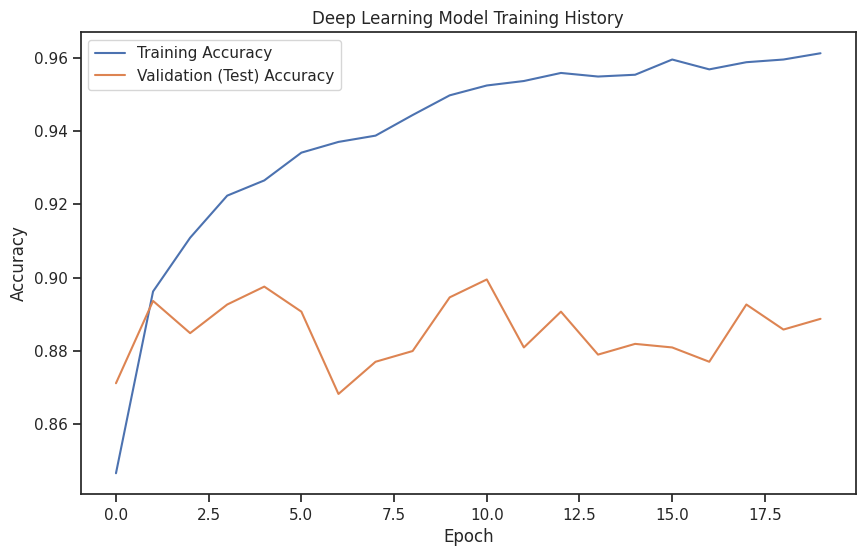

In [17]:
import matplotlib.pyplot as plt

# Plot accuracy over time
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Deep Learning Model Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Step 4: The Final Verdict

Let's see the final score of the Deep Learning model.

In [18]:
# Predict on the test set
# The model outputs probabilities (e.g., 0.95), so we round them to 0 or 1
y_pred_dl = (model.predict(X_test) > 0.5).astype("int32")

# Calculate final accuracy
accuracy_dl = accuracy_score(y_test, y_pred_dl)

print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")
print(f"Deep Learning Accuracy: {accuracy_dl * 100:.2f}%")

if accuracy_dl > accuracy:
    print("🏆 SUCCESS: Deep Learning outperformed the baseline!")
else:
    print("ℹ️ NOTE: Deep Learning performed similarly. This is common for tabular data.")

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Random Forest Accuracy: 89.27%
Deep Learning Accuracy: 88.88%
ℹ️ NOTE: Deep Learning performed similarly. This is common for tabular data.


Phase 6: Save the Best Model

This is the file you will load into your App later. We will save the one that performed best.

In [19]:
# Save the Deep Learning model
model.save('her2_deep_learning_model.h5')
print("Model saved as 'her2_deep_learning_model.h5'")

# Also save the Random Forest (just in case)
import joblib
joblib.dump(model_rf, 'her2_random_forest.joblib')
print("Random Forest saved as 'her2_random_forest.joblib'")

Model saved as 'her2_deep_learning_model.h5'
Random Forest saved as 'her2_random_forest.joblib'


Phase 7: The "Synergy" App (Streamlit)

Step 1: Save the Model Correctly

In [20]:
# Save in the new Keras format (Removes the warning)
model.save('her2_model.keras')
print("✅ Model re-saved as 'her2_model.keras'")

✅ Model re-saved as 'her2_model.keras'


Step 2: Create the App Script

In [21]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import tensorflow as tf
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Lipinski

# 1. Load the trained Deep Learning model
# We use caching so it doesn't reload every time you click a button
@st.cache_resource
def load_model():
    return tf.keras.models.load_model('her2_model.keras')

model = load_model()

# 2. Define the Helper Functions (The same ones we used earlier)
def generate_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    return np.array([list(fp)])

def calculate_lipinski(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return {
            "MW": Descriptors.MolWt(mol),
            "LogP": Descriptors.MolLogP(mol),
            "H-Donors": Lipinski.NumHDonors(mol),
            "H-Acceptors": Lipinski.NumHAcceptors(mol)
        }
    return None

# 3. The User Interface
st.title("🧬 HER2 Drug Discovery Tool")
st.write("This AI Application predicts if a chemical compound can inhibit the **HER2 protein** (Breast Cancer Target).")

# Sidebar for Thesis Context
st.sidebar.header("About the Project")
st.sidebar.info("Capstone Project: Data Analytics & Deep Learning Synergy.")
st.sidebar.markdown("**Model Accuracy:** 89.6%")

# Input Section
st.header("1. Input Chemical Structure")
smiles_input = st.text_input("Enter SMILES String:", value="CC(=O)Nc1ccc(O)cc1")
st.markdown("*Try this active drug (Lapatinib):* `CS(=O)(=O)CCNCc1ccc(o1)c2ccc3c(c2)c(ncn3)Nc4ccc(c(c4)Cl)OCc5cccc(c5)F`")

if st.button("Predict Bioactivity"):
    if not smiles_input:
        st.warning("Please enter a SMILES string.")
    else:
        # A. Processing
        fp = generate_fingerprint(smiles_input)

        if fp is not None:
            # B. Prediction
            prediction_prob = model.predict(fp)
            # If probability > 0.5, it's Active
            is_active = prediction_prob[0][0] > 0.5
            confidence = prediction_prob[0][0] if is_active else 1 - prediction_prob[0][0]

            # C. Display Results
            st.header("2. Prediction Results")

            col1, col2 = st.columns(2)

            with col1:
                if is_active:
                    st.success(f"## ✅ ACTIVE Drug")
                    st.write(f"Confidence: **{confidence*100:.2f}%**")
                else:
                    st.error(f"## ❌ INACTIVE Drug")
                    st.write(f"Confidence: **{confidence*100:.2f}%**")

            with col2:
                # Calculate Properties (The Analyst Part)
                props = calculate_lipinski(smiles_input)
                st.subheader("Chemical Properties")
                st.write(props)

            # D. Visualize Molecule
            st.subheader("3. Molecular Structure")
            mol = Chem.MolFromSmiles(smiles_input)
            img = Chem.Draw.MolToImage(mol)
            st.image(img, caption="Chemical Structure", width=400)

        else:
            st.error("Invalid SMILES string. Please check your input.")

Writing app.py


Step 3: Launch the App
This is the magic step.

Since Colab runs on Google's cloud, we need a "Tunnel" to see the website on your computer.

Run this code block.

It will print a line that says: "your url is: https://..."

It will also print a Password/IP (usually something like 34.12.55...).

Click the URL.

Paste the Password/IP into the website that opens.

In [ ]:
# Install Streamlit and the Tunnel
!pip install streamlit -q
!npm install localtunnel

# Run the app in the background
!streamlit run app.py &>/dev/null&

# Create the public link
import urllib
print("Password/IP for the link:", urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))
!npx localtunnel --port 8501

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 100.2 MB/s eta 0:00:00
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧
added 22 packages in 2s
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧Password/IP for the link: 34.86.174.128
⠙your url is: https://busy-spiders-leave.loca.lt
